# EDA
- check absence of predictors
- check data type
- check missing data, nans and outliers
- check data range
- check imbalance data or skewed data
- any predictors analysis

In [58]:
import pandas as pd
import numpy as np
import yaml
import os
import tqdm
import src.util as util

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Config and Train Datset

In [59]:
# load config
config_data = util.load_config()

# load train dataset
x_train = util.pickle_load(config_data["train_set_path"]["x"])
y_train = util.pickle_load(config_data["train_set_path"]["y"])
dataset = pd.concat([x_train, y_train], axis=1)

dataset.head(5)

,JobLevel,Age,DistanceFromHome,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,MonthlyIncome,MonthlyRate,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,PerformanceRating,Department,JobRole,Gender,OverTime,Attrition
853,1,19,9,1,1,0,0,2552,7172,3,1,3,4,Research & Development,Research Scientist,Male,No,No
435,3,33,15,7,6,7,7,13610,24619,2,3,4,3,Research & Development,Manager,Male,Yes,Yes
587,2,52,11,5,2,1,4,3149,21821,4,3,3,4,Research & Development,Laboratory Technician,Female,No,No
1170,1,27,2,4,2,1,2,2580,6297,4,4,2,3,Research & Development,Research Scientist,Male,No,No
159,1,34,2,4,3,1,2,2231,11314,3,3,3,3,Sales,Sales Representative,Female,No,No


# 2. Check Missing Value and Handling Strategies

In [60]:
dataset.isnull().sum()

JobLevel                   0
Age                        0
DistanceFromHome           0
YearsAtCompany             0
YearsInCurrentRole         0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
MonthlyIncome              0
MonthlyRate                0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
PerformanceRating          0
Department                 0
JobRole                    0
Gender                     0
OverTime                   0
Attrition                  0
dtype: int64

In [61]:
skew_handlings = []

for col in config_data['int64_columns']:
    skew = dataset[col].skew()
    skew_handling = {
        'attribute' : col,
        'skewness' : skew,
        'imputed_by' : 'mean' if abs(skew) < 0.5 else 'median',
        'imputed_value' : round(dataset[col].mean()) if abs(skew) < 0.5 else round(dataset[col].mean())
    }
    skew_handlings.append(skew_handling)

for col in config_data['object_columns']:
    if col == 'Attrition': continue
    skew_handling = {
        'attribute' : col,
        'skewness' : '-',
        'imputed_by' : 'mode',
        'imputed_value' : dataset[col].mode()[0]
    }
    skew_handlings.append(skew_handling)

missing_value_config = {}
for i in range(len(skew_handlings)):
    missing_value_config[f"{skew_handlings[i]['attribute']}"] = skew_handlings[i]['imputed_value'] 

print(yaml.dump({'missing_value_handling' : missing_value_config}))

missing_value_handling:
  Age: 37
  Department: Research & Development
  DistanceFromHome: 9
  EnvironmentSatisfaction: 3
  Gender: Male
  JobLevel: 2
  JobRole: Sales Executive
  JobSatisfaction: 3
  MonthlyIncome: 6548
  MonthlyRate: 14465
  OverTime: 'No'
  PerformanceRating: 3
  WorkLifeBalance: 3
  YearsAtCompany: 7
  YearsInCurrentRole: 4
  YearsSinceLastPromotion: 2
  YearsWithCurrManager: 4



In [62]:
dataset[col].mode()

0    No
Name: OverTime, dtype: object

# 3. Label Distribution

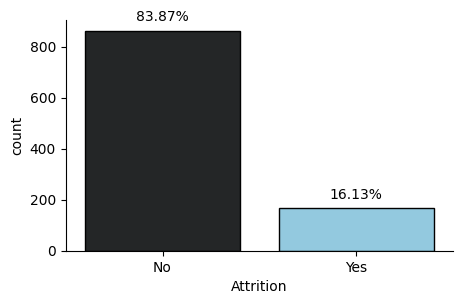

In [63]:
plt.figure(figsize=(5,3))
ax = sns.countplot(data=dataset, x='Attrition', hue='Attrition', palette='dark:skyblue', edgecolor='black')
total_height = len(dataset)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_height) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
sns.despine()
plt.show()

In [64]:
config_data['object_columns']

['Attrition', 'Department', 'JobRole', 'Gender', 'OverTime']

# 4. Variable Distribution toward Label 

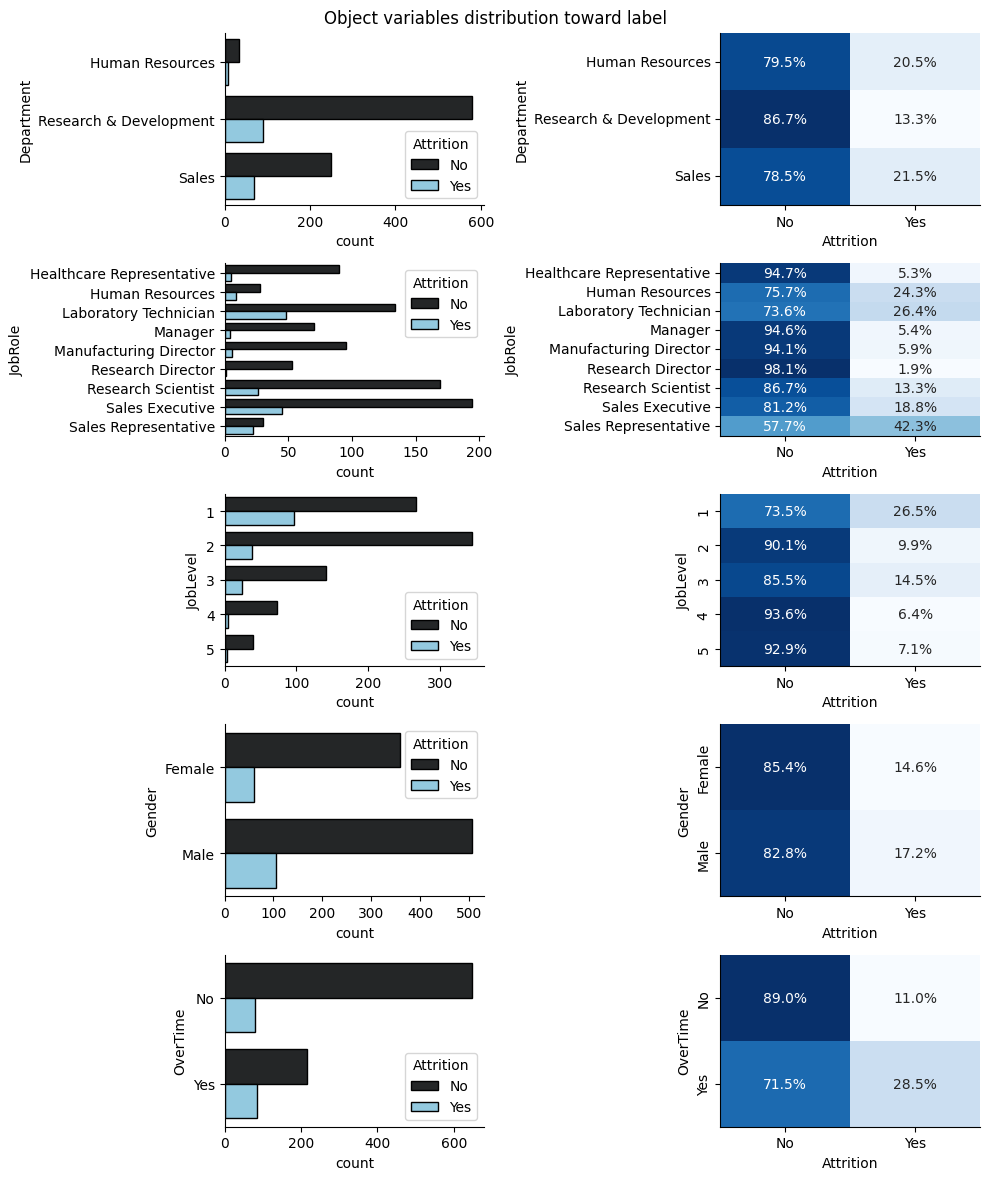

In [65]:
fig, axs = plt.subplots(5,2,figsize=(10,12))
i = 0
cols = ['Department', 'JobRole', 'JobLevel', 'Gender', 'OverTime']

for col in cols:
    if col == 'Attrition': 
        continue
    sns.countplot(ax=axs[i,0], data=dataset.sort_values(by=col), y=col, hue='Attrition', palette='dark:skyblue', edgecolor='black')

    ct = pd.crosstab(dataset[col], dataset['Attrition'], normalize='index')
    sns.heatmap(ax=axs[i,1], data=ct, annot=True, cmap='Blues', fmt='.1%', cbar=False)

    i=i+1

sns.despine()
plt.suptitle('Object variables distribution toward label')
plt.tight_layout()
plt.show()

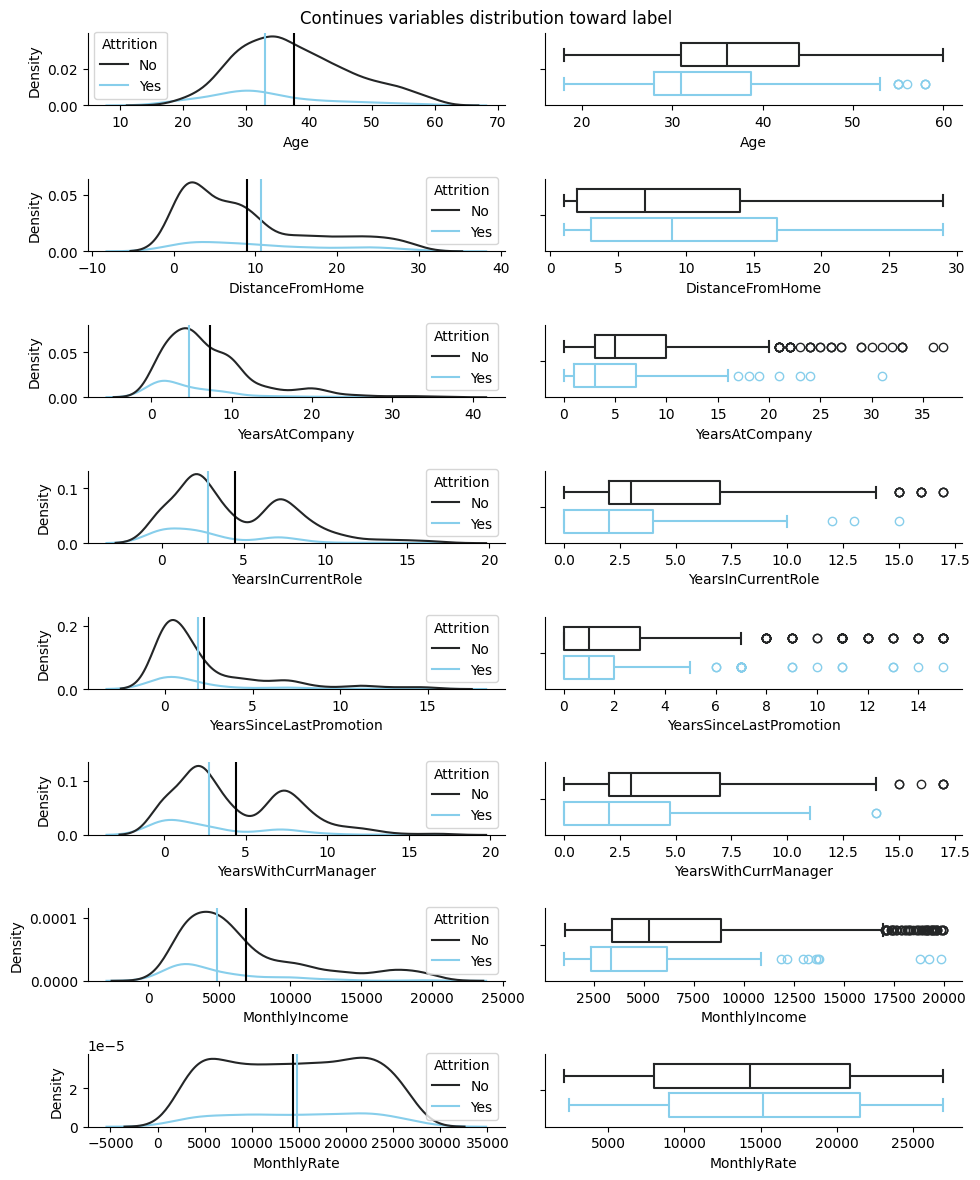

In [66]:
fig, axs = plt.subplots(8,2,figsize=(10,12))
i = 0
cols = ['Age', 'DistanceFromHome', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'MonthlyIncome', 'MonthlyRate']

for col in cols:
    x = col

    sns.kdeplot(ax=axs[i,0], data=dataset, x=x, hue='Attrition', palette='dark:skyblue', fill=False)
    axs[i,0].axvline(dataset[dataset['Attrition'] == 'Yes'][x].mean(), 0, 1, color = "skyblue")
    axs[i,0].axvline(dataset[dataset['Attrition'] == 'No'][x].mean(), 0, 1, color = "black")

    sns.boxplot(ax=axs[i,1], data=dataset, x=x, hue='Attrition', palette='dark:skyblue', gap=0.2, fill=False)
    axs[i,1].legend().set_visible(False)

    i=i+1

sns.despine()
plt.suptitle('Continues variables distribution toward label')
plt.tight_layout()
plt.show()

In [67]:
from scipy.stats import ttest_ind

cols = ['Age', 'DistanceFromHome', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'MonthlyIncome', 'MonthlyRate']
results = []

for col in cols:
    t_statistic, p_value = ttest_ind(dataset[dataset['Attrition']=='Yes'][col], dataset[dataset['Attrition']=='No'][col])
    result = {
        'attribute' : col,
        't_statistic' : t_statistic, 
        'p_value': p_value, 'result': 
        'Significant difference' if p_value < 0.05 else 'No significant difference'}
    results.append(result)

pd.DataFrame(results)

,attribute,t_statistic,p_value,result
0,Age,-6.008482,2.597301e-09,Significant difference
1,DistanceFromHome,2.482893,1.319081e-02,Significant difference
2,YearsAtCompany,-5.233332,2.017972e-07,Significant difference
3,YearsInCurrentRole,-5.633347,2.281380e-08,Significant difference
4,YearsSinceLastPromotion,-1.406423,1.599011e-01,No significant difference
5,YearsWithCurrManager,-5.559739,3.443780e-08,Significant difference
6,MonthlyIncome,-5.254672,1.802901e-07,Significant difference
7,MonthlyRate,0.616738,5.375439e-01,No significant difference


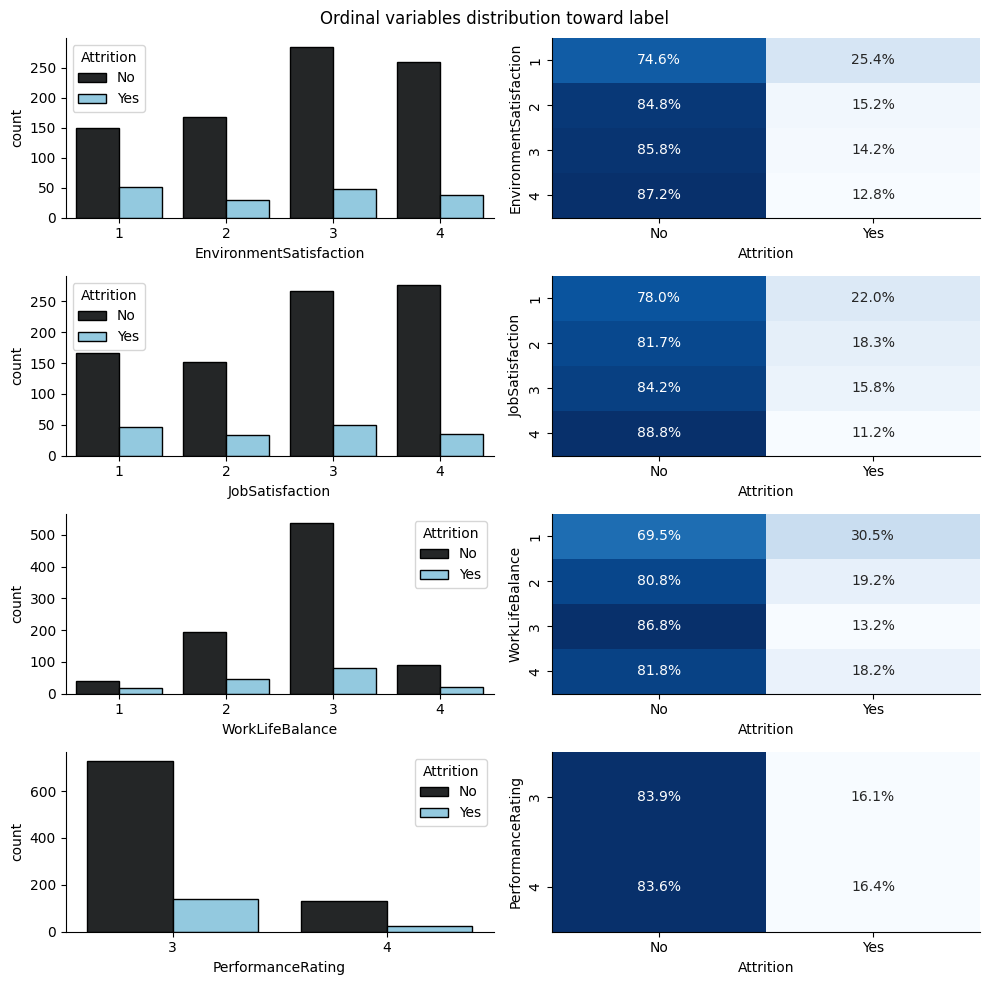

In [68]:
fig, axs = plt.subplots(4,2,figsize=(10,10))
i = 0
cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'PerformanceRating',]

for col in cols:
    x = col
    sns.countplot(ax=axs[i,0], data=dataset.sort_values(by='Attrition'), x=x, hue='Attrition', palette='dark:skyblue', edgecolor='black', fill=True)

    ct = pd.crosstab(dataset[col], dataset['Attrition'], normalize='index')
    sns.heatmap(ax=axs[i,1], data=ct, annot=True, cmap='Blues', fmt='.1%', cbar=False)

    i=i+1

sns.despine()
plt.suptitle('Ordinal variables distribution toward label')
plt.tight_layout()
plt.show()

# 5. Correlation

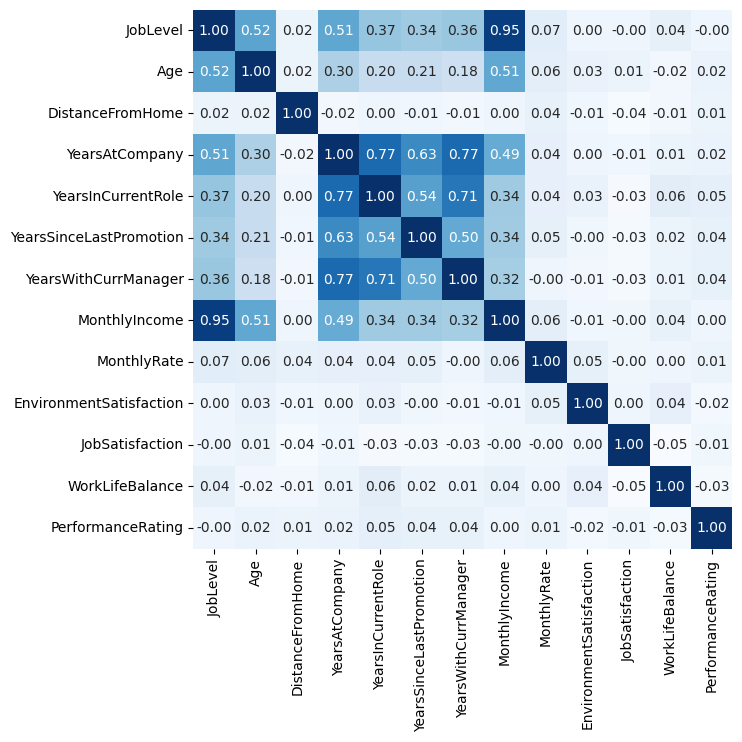

In [69]:
plt.figure(figsize=(7,7))
sns.heatmap(dataset.corr(numeric_only = True), cmap='Blues', annot=True, fmt=".2f", square=True, cbar=False)
plt.show()

# Conclusion

1. **Missing Values:**
   - No missing values in the train dataset; no further action needed.
   - For future data defence, we use missing value impute strategy as follows:
      - Using mean if the attribute is numerical and have skewness near 0
      - Using median if the attribute is numerical and have > 0.5 of skewness
      - Using mode if the attribute is categorical

2. **Label Distribution:**
   - Imbalanced dataset, positive attrition is only 16%.
   - Suggestion: Consider resampling techniques (undersampling/oversampling/SMOTE).

3. **Object Variables:**
   - Significant differences in attrition rates for several variables.
   - Keep all object variables as predictors except gender.

4. **Continuous Variables:**
   - Most continuous variables show lower values correlating with higher attrition, except DistanceFromHome.
   - T-test finds no significant difference for YearsSinceLastPromotion and MonthlyRate.
   - Implication: Drop non-significant variables - YearsSinceLastPromotion, MonthlyRate.

5. **Ordinal Variables:**
   - Lower values in ordinal variables generally associated with higher attrition.
   - Exception: PerformanceRating has no clear pattern.
   - Implication: Drop PerformanceRating as a predictor.

6. **Correlation:**
   - JobLevel and MonthlyIncome exhibit high correlation, suggesting potential multicollinearity.
   - Despite the correlation, both are influential predictors of attrition, and it's decided not to drop either variable.

In [70]:
pred_target_config = {
    'predictor_columns' : list(dataset.columns.drop(['Gender', 'YearsSinceLastPromotion', 'MonthlyRate', 'Attrition'])),
    'target_column' : 'Attrition'
 }

print(yaml.dump(pred_target_config))

predictor_columns:
- JobLevel
- Age
- DistanceFromHome
- YearsAtCompany
- YearsInCurrentRole
- YearsWithCurrManager
- MonthlyIncome
- EnvironmentSatisfaction
- JobSatisfaction
- WorkLifeBalance
- PerformanceRating
- Department
- JobRole
- OverTime
target_column: Attrition

